In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier
from matplotlib import style

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
#loading data
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

#setting y to 0-1 binary variable
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)

#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag']

#used stratified, because of the distribution of y (it's skewed)
idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=999)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

#selecting numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns

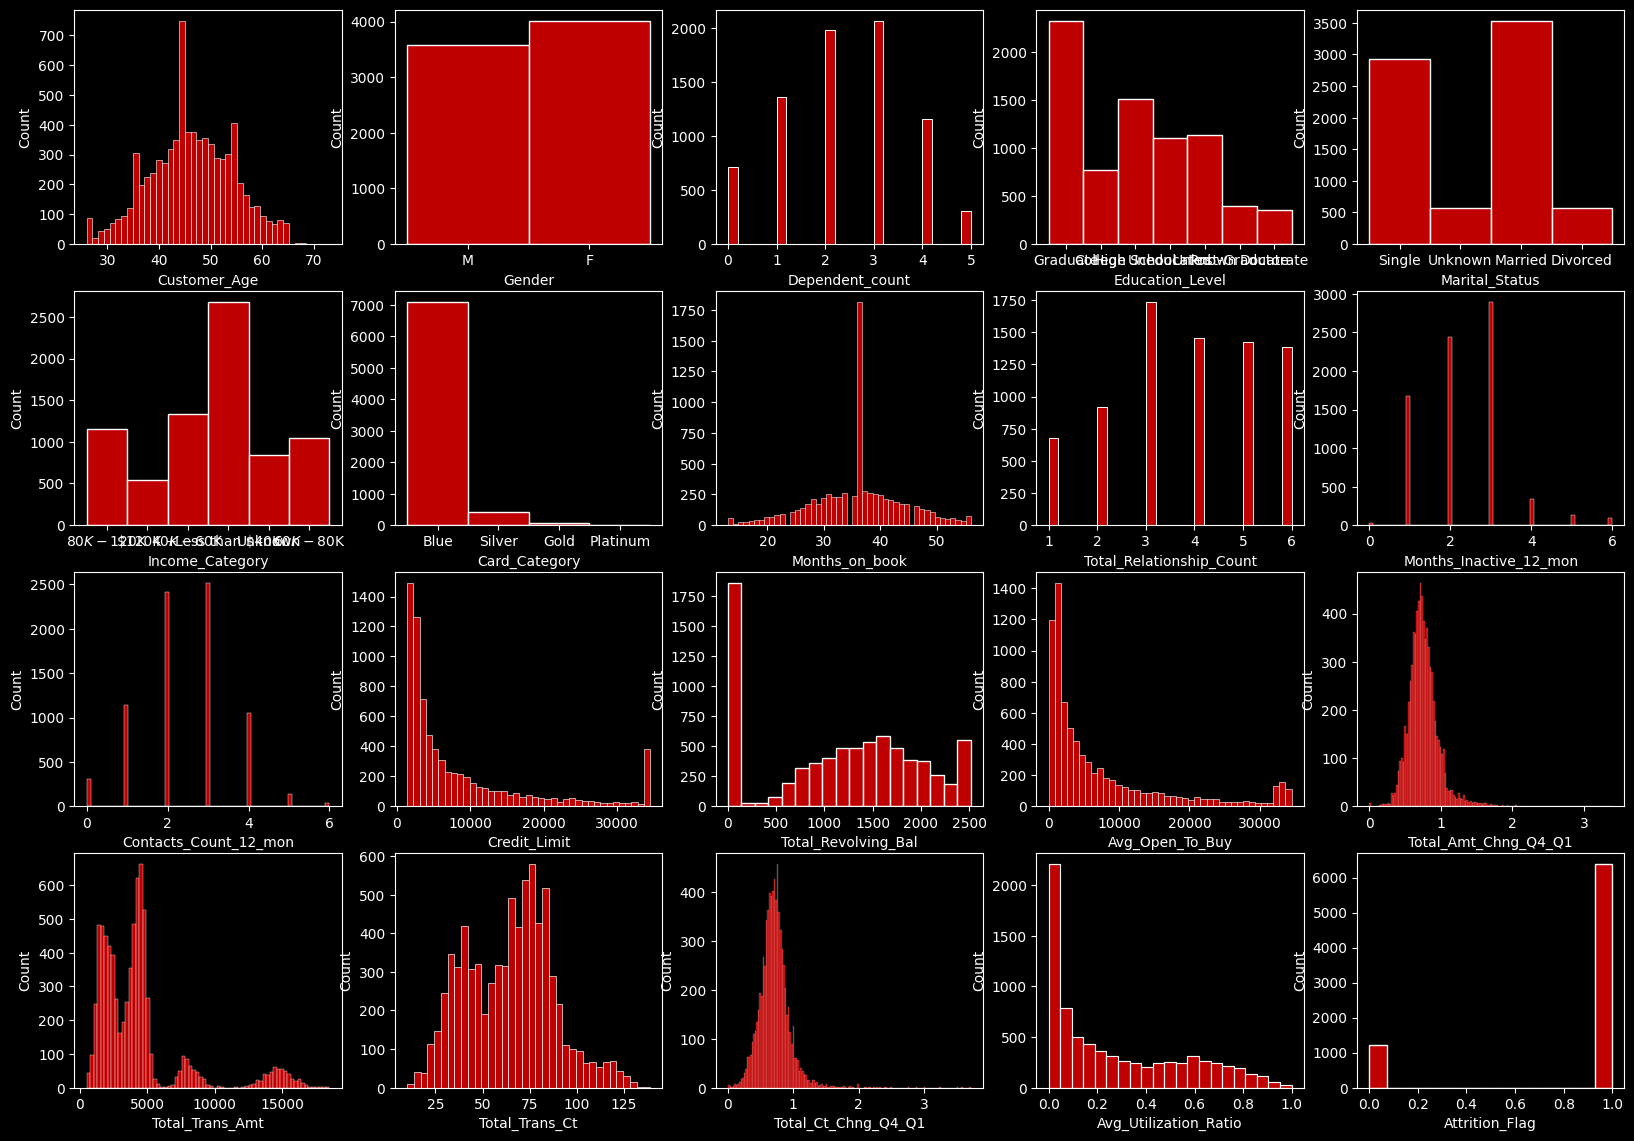

In [7]:
#displaying distribution of the data

plt.figure(figsize=(20,14))
k=1
for i in X_train.columns:
    plt.subplot(4,5,k)
    sns.histplot(X_train[i])
    k+=1
plt.subplot(4,5,k)
sns.histplot(y_train)
plt.show()

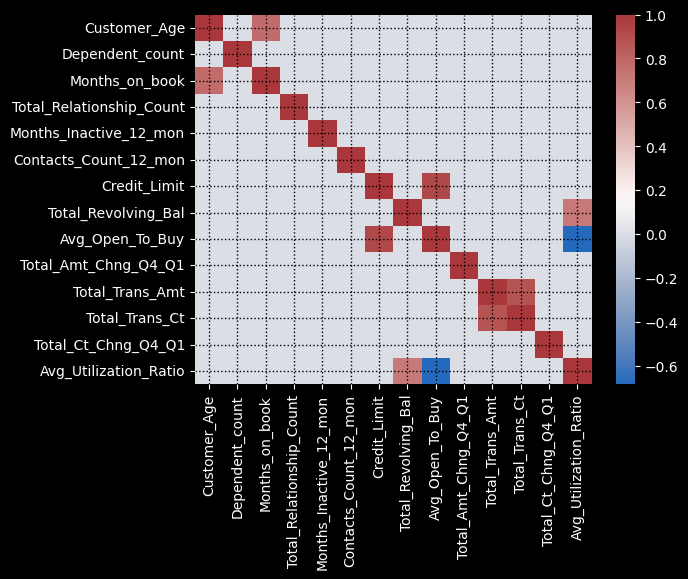

In [11]:
corr_mat = X_train[numerical_columns].corr('spearman', numeric_only=True)
corr_mat[np.abs(corr_mat) < 0.5] = 0
sns.heatmap(corr_mat, cmap="vlag")
plt.grid(lw=1, color='black', linestyle='dotted')
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [42]:
#building model
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

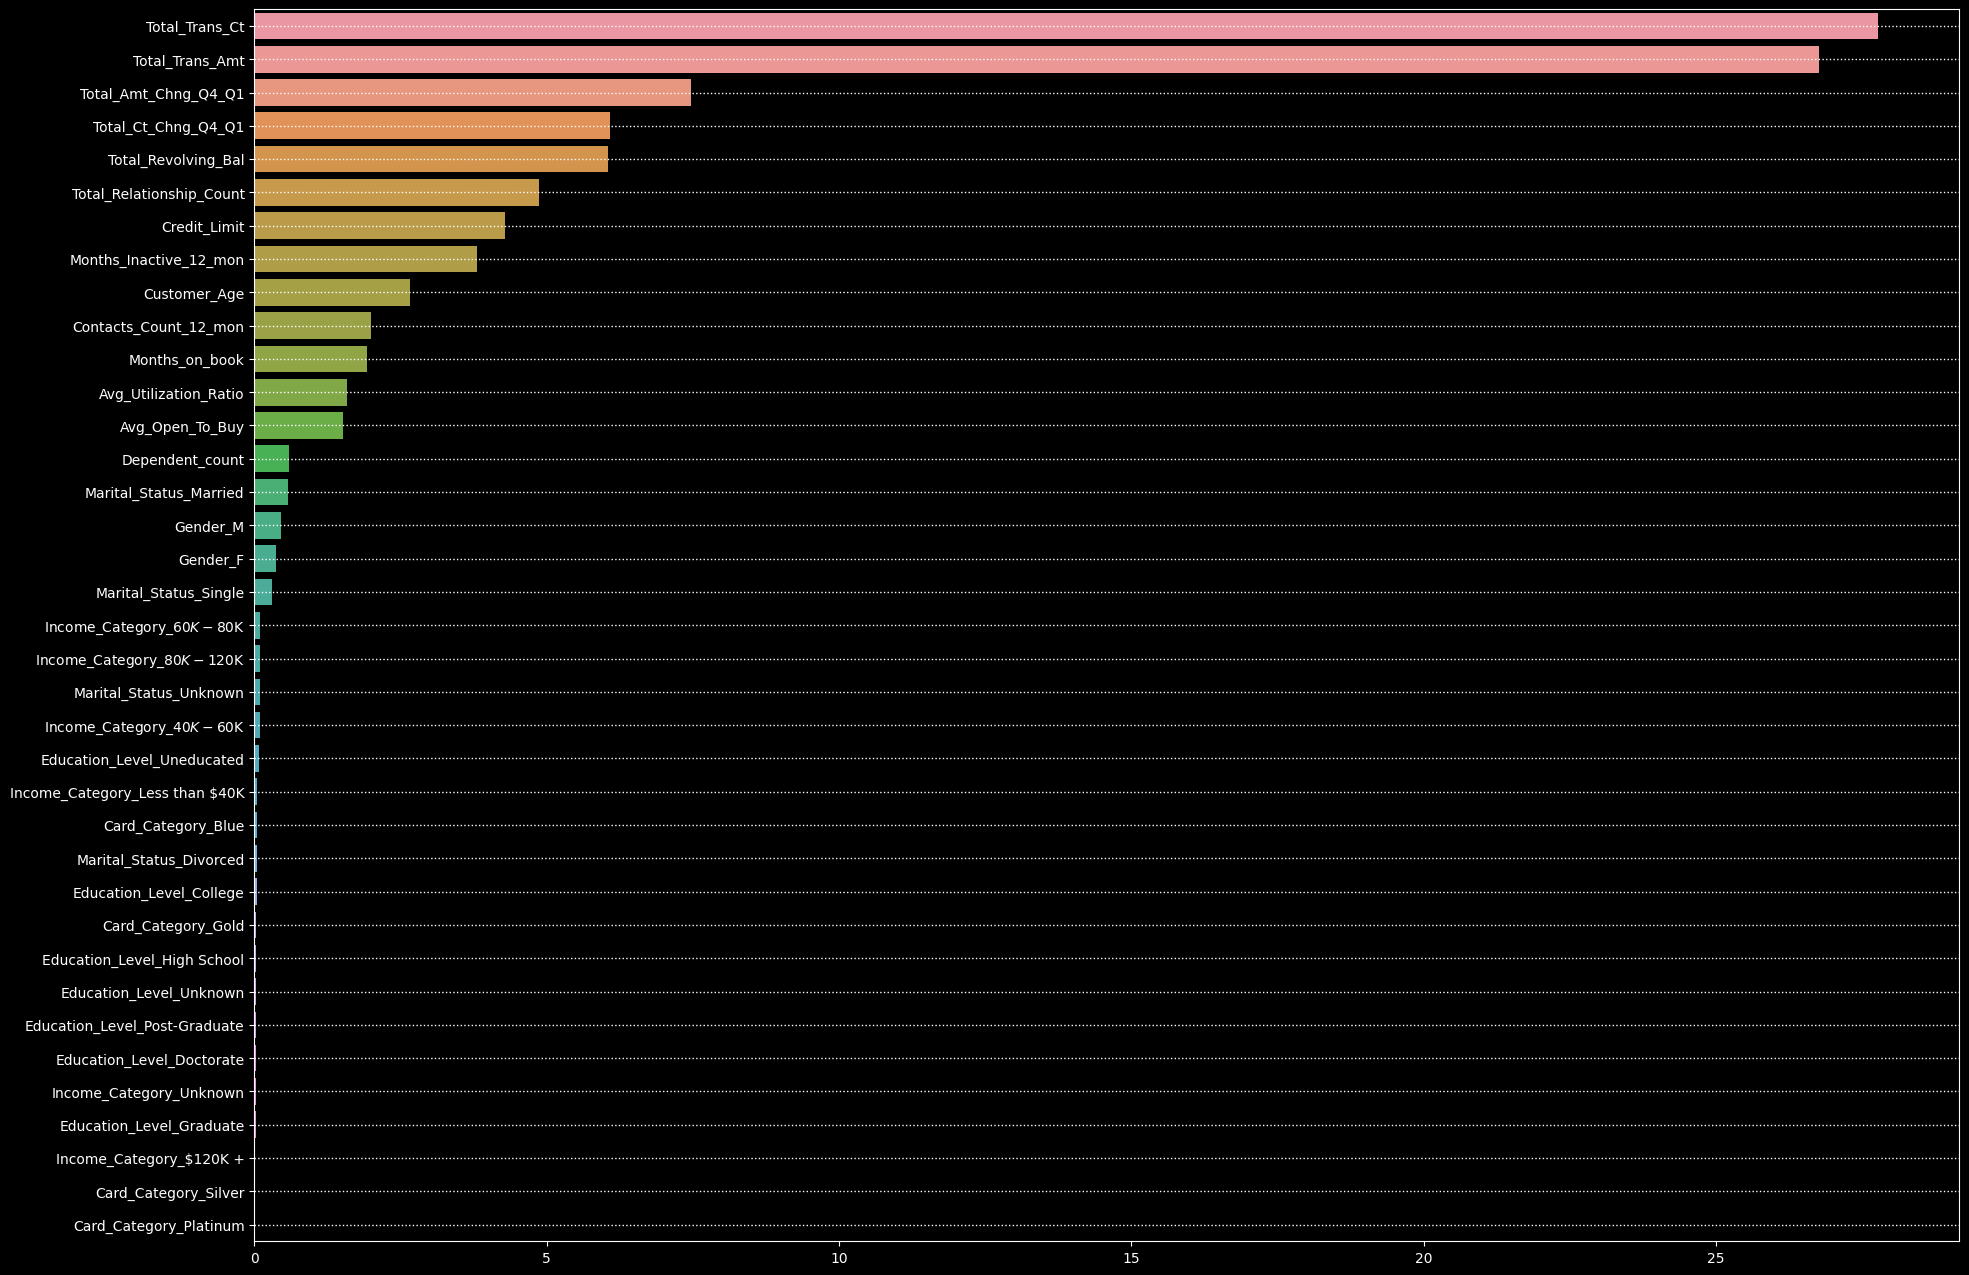

In [59]:
importances = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns)
plt.figure(figsize=(22,16))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [41]:
roc_auc_score(y_pred, y_test)

0.9664397905759162

In [36]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.02448599